In [22]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.utils import data_generator
# from TCN.mnist_pixel.model import TCN
from TCN.mnist_pixel.model import RNNModel
import numpy as np
import argparse

# set default values for model
batch_size = 64
cuda = True
dropout = 0.0
clip = 1
epochs = 10
num_layers = 1
levels = 8
log_interval = 100
lr = 1e-3
optimm = 'RMSprop'
nhid = 128
seed = 1111
permutee = False
root = '../data/mnist'
save_filename = './checkpoints/mnist/mnist_real_0.1_rnn.pt'
n_inputs = 1
n_classes = 10
seq_length = 784
steps = 0

In [23]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.MNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.MNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = data_generator(root, batch_size)

# classes = ('tshit/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle/boot')
# print(classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


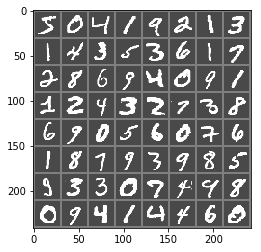

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


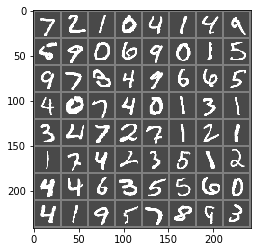

In [25]:
# sanity check for validation data
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [26]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
channel_sizes = [nhid] * levels
model = RNNModel(rnn_type="LSTM", ntoken=n_classes, ninp=n_inputs, nhid=nhid, nlayers=num_layers)

# model = nn.DataParallel(model)
# model.to(device)
model.cuda()

permute = permute.cuda()
# permute = permute.to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)

torch.Size([512, 128])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
torch.Size([512, 128])


In [62]:
def trainTCN(ep):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: 
            data, target = data.to(device), target.to(device)
        data = data.view(-1, batch_size, seq_length)
#         [64, 1, 784]

        print(list(data.size()))
        if permutee:
            data = data[:, :, permute]
#            Data should be seq_len, batch, input_size
#         data = data.permute(seq_length, batch_size, 1)
        model.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
#         loss_.append(train_loss)
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_loss = 0

In [63]:
def testTCN():
    test_loss = 0
    correct = 0
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, 1, seq_length)
            if permutee:
                data = data[:, :, permute]
#             data = data.permute(2, 0, 1)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
#             _, pred = output.data.max(1, keepdim=True)
            _, pred = torch.max(output, 1)
#             print(pred)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(target.data.view_as(pred)))
            c = (pred == target).squeeze()
            tot += 1
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracy_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [64]:
def save(model):
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

In [65]:
accuracy_ = []
loss_ = []
# def runModel():
for epoch in range(1, epochs+1):
    trainTCN(epoch)
    testTCN()
    if epoch % 5 == 0: 
        print('Saving model.....')
        save(model) 
    if epoch % 10 == 0:
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            

[1, 64, 784]


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 784

In [22]:
with open(save_filename, 'rb') as f:
        model = torch.load(f)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

68362

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(20)
# s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, accuracy_)

ax.set(xlabel='Epoch', ylabel='Accuracy',
       title='TCN')
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
print(model)